### General Utilities

In [1]:
import numpy as np
import pandas as pd
import os
import datetime
from pathlib import Path
import janitor
import re

### Data Visualization

In [567]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

from matplotlib_inline.backend_inline import flush_figures
import plotly.express as px

plt.rcParams['figure.figsize'] = [12, 8]

### Data Preprocessing

In [152]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import ruptures as rpt

### Model Training and Evaluation

In [4]:
# Classical Models
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Machine Learning Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Gradient Boosting Models
import xgboost as xgb
from xgboost import plot_importance
import lightgbm as lgb
#import catboost as cb

In [131]:
# Time-Series Specific
import stumpy  # For time series similarity and matrix profiles
#import darts  # Unified time series modeling library
#from darts.models import ExponentialSmoothing, RNNModel, ARIMA, Prophet

# Feature Engineering
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

In [6]:
# load in processed data
df = pd.read_csv('../data/processed/final_df.csv', parse_dates=['ds'])

In [7]:
df_clean = df.clean_names() # clean column names for consistency

In [9]:
# Select relevant columns for analysis
daily_cols = ['ndic_file_no', 'api_no', 'well_type', 'well_status',
       'latitude','longitude', 'current_operator', 'current_well_name', 'total_depth',
       'field', 'perfs', 'filenumber','well_id','ds', 'producing_days', 'y', 'daily_gas_rate',
       'daily_water_rate', 'cumulative_oil_bbls', 'cumulative_gas_mcf',
       'cumulative_wtr_bbls', 'rolling_oil_mean', 'rolling_oil_std',
       'is_outlier', 'trend', 'yhat', 'yhat_lower', 'yhat_upper']
daily_df = df_clean[daily_cols]

In [10]:
# Filter for wells with status 'A' (active wells)
daily_df = daily_df.query(
    "well_status == 'A'"
)

# Rename column 'y' to 'daily_oil_rate' for clarity
daily_df = daily_df.rename(columns={'y':'daily_oil_rate'})
# Fill missing rolling oil mean values with daily oil rate
daily_df['rolling_oil_mean'] = daily_df['rolling_oil_mean'].fillna(daily_df['daily_oil_rate'])

In [11]:
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42842 entries, 1 to 46303
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ndic_file_no         42842 non-null  int64         
 1   api_no               42842 non-null  object        
 2   well_type            42842 non-null  object        
 3   well_status          42842 non-null  object        
 4   latitude             42842 non-null  float64       
 5   longitude            42842 non-null  float64       
 6   current_operator     42842 non-null  object        
 7   current_well_name    42842 non-null  object        
 8   total_depth          42842 non-null  float64       
 9   field                42842 non-null  object        
 10  perfs                42019 non-null  object        
 11  filenumber           42842 non-null  int64         
 12  well_id              42840 non-null  float64       
 13  ds                   42840 non-null 

In [ ]:
# let's start with ARIMA just to get a general baseline 
import warnings

# Suppress specific warning
warnings.filterwarnings("ignore", message="A date index has been provided, but it has no associated frequency information")
warnings.filterwarnings("ignore", message="No supported index is available. Prediction results will be given with an integer index beginning at `start`.")
warnings.filterwarnings("ignore", message="No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception")
# only need target and date columns

arima_df = daily_df[['ds','current_well_name','daily_oil_rate']]

# Ensure the data is sorted by date and well
arima_df = arima_df.sort_values(['current_well_name','ds'])
# loop through each well and fit ARIMA
arima_well_models = {}

for well, group in arima_df.groupby('current_well_name'):    
    # Set date to index
    group = group.set_index('ds')
    # Remove rows where 'daily_oil_rate' is NaN
    group = group.dropna(subset=['daily_oil_rate'])
    
    if group['daily_oil_rate'].notnull().sum() > 0:
        try:            
            target_series = group['daily_oil_rate'].dropna()           
            # Fit ARIMA (choose appropriate parameters or use auto_arima)
            print(f"Fitting ARIMA for Well: {well}")
            model = ARIMA(target_series, order=(1, 1, 1), enforce_stationarity=False, enforce_invertibility=False) 
            fitted_model = model.fit()
            forecast = fitted_model.forecast(steps=12)    
            
            # Save the model
            arima_well_models[well] = [fitted_model.fittedvalues,forecast]
            
        except RuntimeError as e:
            print(f'error {e} fitting well {well}')
    else:
        print(f"{well} has no valid data after handling missing values. Skipping.")

In [116]:
def plot_arima_well(df,well):
    """
    Plot Prophet forecast with actual data and highlight outliers.

    Parameters:
    - forecast: The forecast dataframe from the model.
   
    """
    # Filter the data for the specific well_id
    # Extract fitted and forecasted values
    time = arima_well_models[well][0].index.values
    fitted_values = arima_well_models[well][0].values
    forecast_values = arima_well_models[well][1]    
    well_data = arima_df[arima_df['current_well_name'] == well].dropna()    
    
    # Plot the actual vs forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(time, well_data['daily_oil_rate'], label='Actual Daily Oil Rate', color='green', marker='o', linestyle='-')
    plt.plot(time, fitted_values, label='Arima Fit Daily Oil Rate', color='blue', linestyle='--')  
    # Extend the time index for the forecasted values
    last_date = time[-1]  # Last date in the fitted values
    # Add forecasted values
    forecast_time = pd.date_range(start=last_date, periods=len(forecast_values) + 1, freq='ME')[1:] 
    plt.plot(forecast_time, forecast_values.values, label='ARIMA Forecast Daily Oil Rate', color='red', linestyle='--')
    
    # Add titles and labels
    plt.title('Actual vs Forecasted Daily Oil Rate for Well 18406')
    plt.xlabel('Days')
    plt.ylabel('Daily Oil Rate')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    
    # Show the plot
    plt.show()

C:\Users\alley\AppData\Local\Temp\ipykernel_17424\3066981272.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_time = pd.date_range(start=last_date, periods=len(forecast_values) + 1, freq='M')[1:]


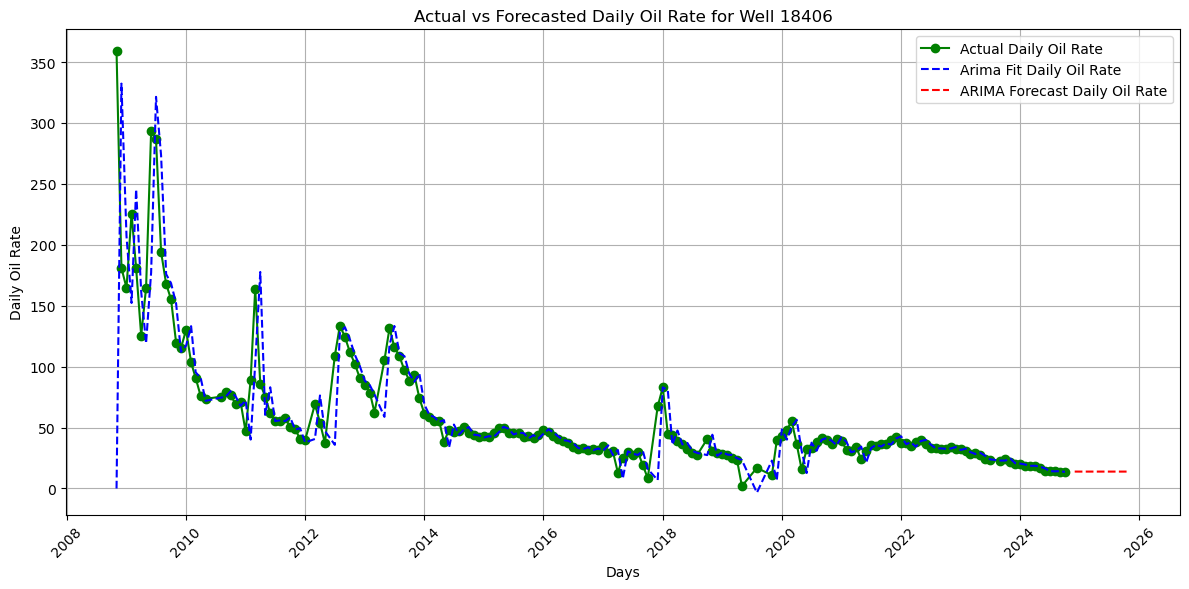

In [115]:
# Example usage:
pd.set_option('future.no_silent_downcasting', True)
well = 'BAKKE  11-24H' # Replace with the desired File Number

plot_arima_well(arima_df, well)

In [127]:
def wrapped_plot_arima_well(well):
    plot_arima_well(arima_df, well)
# Widgets
well_list =  sorted(arima_df['current_well_name'].unique())

# Create a dropdown for well selection
dropdown = widgets.Dropdown(options=well_list, description='Select Well:')

# Create an interactive widget
interactive_plot = widgets.interactive(wrapped_plot_arima_well, well=dropdown)


# Display the interactive plot
display(interactive_plot)


interactive(children=(Dropdown(description='Select Well:', options=('AMUNDSON 23-14H', 'ANDERSON  11-13H', 'AN…

## Commentary on ARIMA Model Performance

The ARIMA models applied to this dataset produce forecasts that are nearly flat (constant production rates) beyond the historical data. This behavior is likely due to the following reasons:

1. **Non-Stationary Data**:
   - Oil production data often exhibits non-stationary patterns, including trends, or abrupt declines over time. ARIMA models require the data to be stationary, and the flat forecasts suggest that these patterns were not fully accounted for in the preprocessing steps (e.g., insufficient differencing).
   - Maybe go back and fit on diff.

2. **Limited Parameter Tuning**:
   - The `(1,1,1)` parameterization of ARIMA was applied across all wells without extensive tuning. This one-size-fits-all approach may fail to capture the unique production behaviors of individual wells.

3. **ARIMA’s Inherent Limitations**:
   - ARIMA is fundamentally a linear model and may struggle to capture complex, non-linear behaviors or external influences such as operational changes, reservoir heterogeneity, or interventions that are common in oil and gas production.

### Next Steps
Given these challenges, it's worth exploring other models that might better capture the dynamic behavior of the data:

1. **Tree-Based Models**:
   - Models like Gradient Boosting Machines (GBMs), XGBoost, or LightGBM can leverage historical features and interactions, offering non-linear modeling capabilities.

2. **Time-Series Specific Models**:

   - **Stumpy**: A Python library designed for matrix profile computation, which can help identify patterns, motifs, and anomalies in time series data. Stumpy is well-suited for understanding recurring trends and identifying subsequences with similar behaviors.
   - **Prophet**: While not tree-based, Prophet by Facebook is a robust model for capturing seasonality and trend components in time-series data.
   - **Hybrid Models**: Combining traditional time-series methods with feature engineering for use in tree-based models could also yield better results.

### Conclusion
The current results underscore the limitations of ARIMA in this context, especially when dealing with complex, non-stationary oil production data. Transitioning to more advanced or tailored modeling approaches is likely to yield more actionable insights and robust forecasts.


In [143]:
ts_df = arima_df.copy()
# Generate lag features
for lag in range(1, 13):  # Lags for the last 12 months
    ts_df[f'lag_{lag}'] = ts_df.groupby('current_well_name')['daily_oil_rate'].shift(lag)

# Generate rolling aggregates
ts_df['rolling_mean_3'] = ts_df.groupby('current_well_name')['daily_oil_rate'].rolling(3).mean().reset_index(0, drop=True)
ts_df['rolling_std_3'] = ts_df.groupby('current_well_name')['daily_oil_rate'].rolling(3).std().reset_index(0, drop=True)


In [ ]:
#TODO: also want to try change detection with ruptures on a log log scale? 

In [186]:
# Calculate log time and log rate for break point detection analysis
daily_df = daily_df.assign(
    log_time = np.log(daily_df['producing_days'].replace(0,1e-6).astype(float)),
    log_rate = np.log(daily_df['rolling_oil_mean'].replace(0,1e-6).astype(float))
)

In [451]:

def change_point_detection(daily_df,well,n_bkps):
   
    # Filter data for a specific well
    well_data = daily_df[daily_df['current_well_name'] == well]
    well_ip = well_data[well_data['producing_days'] < 180]['daily_oil_rate'].max()
    # Find the index of the row where daily_oil_rate equals the IP max
    ip_index = well_data[well_data['daily_oil_rate'] == well_ip].index[0]
    # Filter the data to start at the IP max index
    well_data = well_data.loc[ip_index:]
    log_signal = well_data[['log_time', 'log_rate']].dropna().values  # Signal for detection

    n_bkps = 2  # number of breakpoints    
    algo = rpt.KernelCPD(kernel="linear", min_size=2).fit(log_signal)  # written in C            
    result = algo.predict(n_bkps=n_bkps)

    # Visualize with ruptures' built-in display
    rpt.display(log_signal, result)  # Display detected change points
    plt.title("Change Point Detection on Log-Log Scale")
    plt.xlabel("Time Index")
    plt.ylabel("Log-Scaled Values")
    plt.show()

    # Back-transform change points
    original_cp_indices = np.exp(log_signal[result[:-1], 0])  # Map log-scale time back to original
    original_signal = well_data[['producing_days', 'daily_oil_rate']].dropna()

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the original signal
    ax.plot(
        original_signal['producing_days'], 
        original_signal['daily_oil_rate'], 
        label="Original Signal"
    )
    
    # Add change points and slopes
    for cp in original_cp_indices:
        # Add change point line
        ax.axvline(x=cp, color='red', linestyle='--', label=f"Change Point at {cp:.2f}")
    
        # Get the y-coordinate at the change point
        cp_y = original_signal.loc[original_signal['producing_days'] >= cp, 'daily_oil_rate'].iloc[0]
    
        # Generate slope lines starting from the change point
        slope_time = np.linspace(cp, original_signal['producing_days'].max(), 100)
        half_slope = cp_y * (slope_time / cp) ** -0.5  # y = cp_y * (x/cp)^(-1/2)
        unit_slope = cp_y * (slope_time / cp) ** -1.0  # y = cp_y * (x/cp)^(-1)
    
        # Plot slope lines
        ax.plot(slope_time, half_slope, color='green', linestyle='--', label="Half Slope (-1/2)" if cp == original_cp_indices[0] else "")
        ax.plot(slope_time, unit_slope, color='purple', linestyle='-.', label="Unit Slope (-1)" if cp == original_cp_indices[0] else "")
    
    # Set log-log scale
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Add titles, labels, and legend
    ax.set_title(f"Change Point Detection in Flow Regimes (Log-Log Scale) for well {well}")
    ax.set_xlabel("Time (Log Scale)")
    ax.set_ylabel("Daily Oil Rate (Log Scale)")
    ax.legend()
    ax.grid(which="both", linestyle="--", linewidth=0.5)
    
    # Show the plot
    plt.show()

    return result


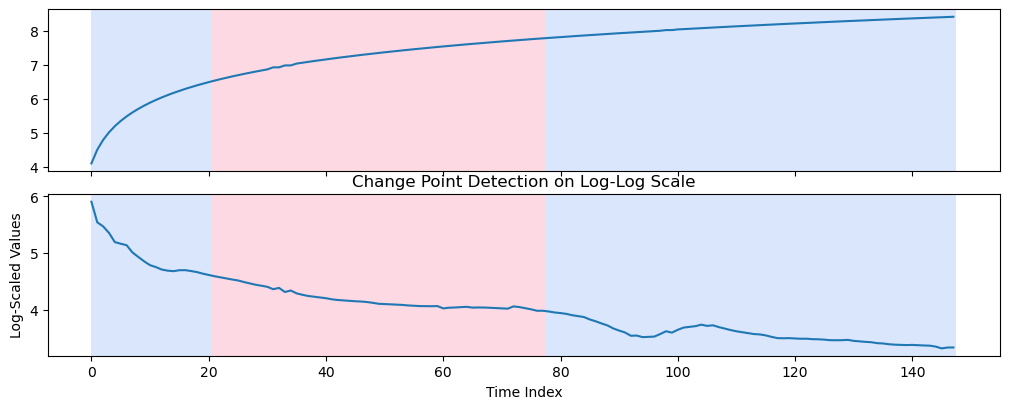

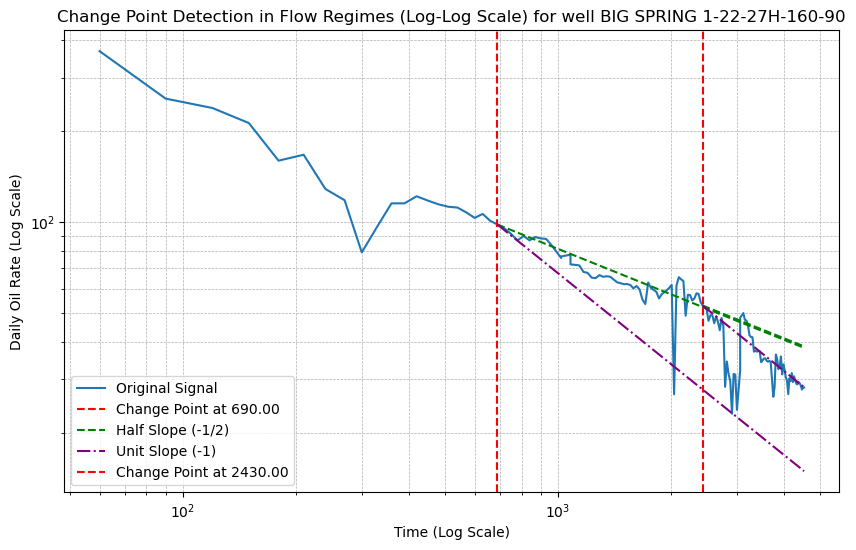

[21, 78, 148]

In [453]:
# Example plot
well = "BIG SPRING 1-22-27H-160-90"
change_point_detection(daily_df, well, 2)

In [ ]:
# this will display the change detection plots for each well
for well in well_list:
    change_point_detection(daily_df, well, 2)

In [286]:
import time 
n_bkps = 2  # number of breakpoints
algo_python = rpt.Dynp(model="l2", jump=1, min_size=2).fit(
    log_signal
)  # written in pure python
algo_c = rpt.KernelCPD(kernel="linear", min_size=2).fit(log_signal)  # written in C

for label, algo in zip(
    ("Python implementation", "C implementation"), (algo_python, algo_c)
):
    start_time = time.time()
    result = algo.predict(n_bkps=n_bkps)
    print(f"{label}:\t{time.time() - start_time:.3f} s, and result is {result}")

Python implementation:	0.684 s, and result is [88, 90, 141]
C implementation:	0.001 s, and result is [88, 90, 141]


In [399]:
# Let's see what ole stumpy can do
# Limit each well to 24 months of production and set the window size to 24
# Calculate matrix profile and see what happens

stump_df = daily_df[['current_well_name','ds','producing_days','rolling_oil_mean','daily_oil_rate' ]].query("producing_days <= 720").dropna()

In [401]:
stump_df = stump_df.set_index(['current_well_name','producing_days'])
stump_df.head()

ds  rolling_oil_mean  daily_oil_rate
current_well_name  producing_days                                             
HEISER TRUST 11-3H 0.0            2007-05-01        104.250000      104.250000
                   30.0           2007-06-01         64.862069       64.862069
                   60.0           2007-07-01         37.566667       37.566667
                   90.0           2007-08-01         41.444444       41.444444
                   120.0          2007-09-01         27.321429       27.321429

In [403]:
m=24
stump_series = stump_df.rolling_oil_mean.values
matrix_profile = stumpy.stump(stump_series, m=m)

In [408]:
motif_idx = np.argsort(matrix_profile[:, 0])[0]

print(f"The motif is located at index {motif_idx}")

The motif is located at index 2627


In [577]:
motif_idx = 223
nearest_neighbor_idx = matrix_profile[motif_idx, 1]

print(f"The nearest neighbor is located at index {nearest_neighbor_idx}")

The nearest neighbor is located at index 3360


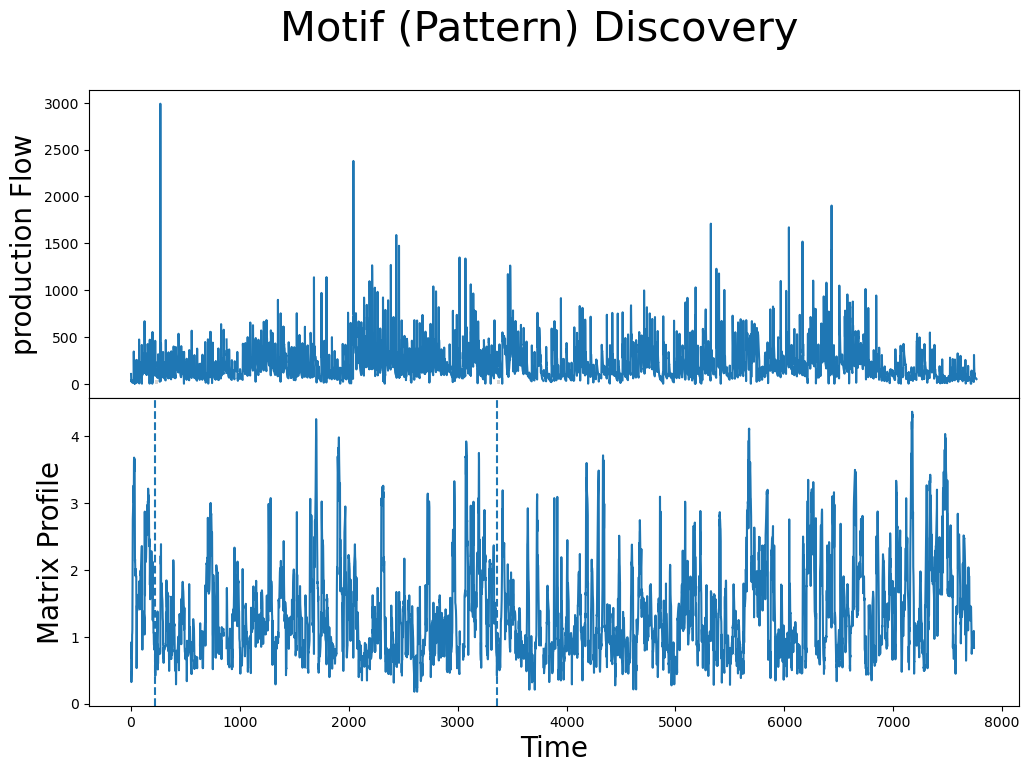

In [578]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(stump_series)
axs[0].set_ylabel('production Flow', fontsize='20')
rect = Rectangle((motif_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((nearest_neighbor_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=motif_idx, linestyle="dashed")
axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
axs[1].plot(matrix_profile[:, 0])
plt.show()

In [571]:
nearest_neighbor_idx

2602

C:\Users\alley\AppData\Local\Temp\ipykernel_17424\831510700.py:24: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



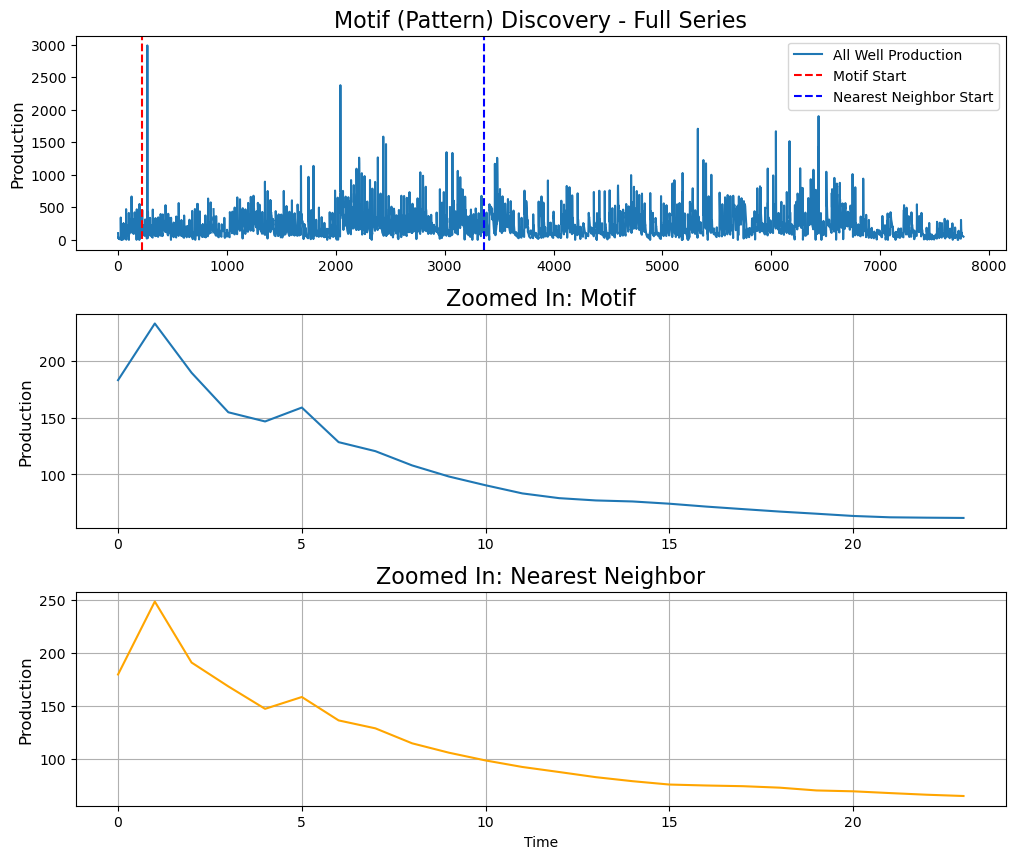

In [583]:

fig, axs = plt.subplots(3, figsize=(12, 10), gridspec_kw={'hspace': 0.3})

# Plot the full time series with highlighted motifs
axs[0].plot(stump_series, label="All Well Production")
axs[0].set_title('Motif (Pattern) Discovery - Full Series', fontsize=16)
axs[0].set_ylabel('Production', fontsize=12)
axs[0].axvline(x=motif_idx, linestyle="dashed", color="red", label="Motif Start")
axs[0].axvline(x=nearest_neighbor_idx, linestyle="dashed", color="blue", label="Nearest Neighbor Start")
axs[0].legend()

# Zoom into the motif region
axs[1].plot(stump_series[motif_idx:motif_idx+m], label="Motif")
axs[1].set_title('Zoomed In: Motif', fontsize=16)
axs[1].set_ylabel('Production', fontsize=12)
axs[1].grid()

# Zoom into the nearest neighbor region
axs[2].plot(stump_series[nearest_neighbor_idx:nearest_neighbor_idx+m], label="Nearest Neighbor", color="orange")
axs[2].set_title('Zoomed In: Nearest Neighbor', fontsize=16)
axs[2].set_ylabel('Production', fontsize=12)
axs[2].grid()

plt.xlabel('Time')
plt.tight_layout()
plt.show()


In [412]:
check_stump_patterns =daily_df[['current_well_name','ds','producing_days','rolling_oil_mean','daily_oil_rate' ]].query("producing_days <= 720").dropna().reset_index()

In [415]:
# Initialize an empty list to store motif-neighbor pairs
motif_neighbor_pairs = []

# Sort the motif indices by their matrix profile distance (similarity measure)
sorted_indices = np.argsort(matrix_profile[:, 0])  # Indices sorted by distance

# Iterate through the sorted motif indices
for motif_idx in sorted_indices:
    # Get the nearest neighbor index for the current motif index
    neighbor_idx = int(matrix_profile[motif_idx, 1])
    
    # Create a pair (tuple) of the motif index and its neighbor
    # Use `sorted()` to ensure that the smaller index always comes first,
    # this helps avoid duplicate pairs like (2640, 4485) and (4485, 2640)    
    pair = tuple(sorted((motif_idx, neighbor_idx)))
    
    # Add the pair if it's not already in the list
    if pair not in motif_neighbor_pairs:
        motif_neighbor_pairs.append(pair)

# Convert to a list if needed
motif_neighbor_pairs = list(motif_neighbor_pairs)

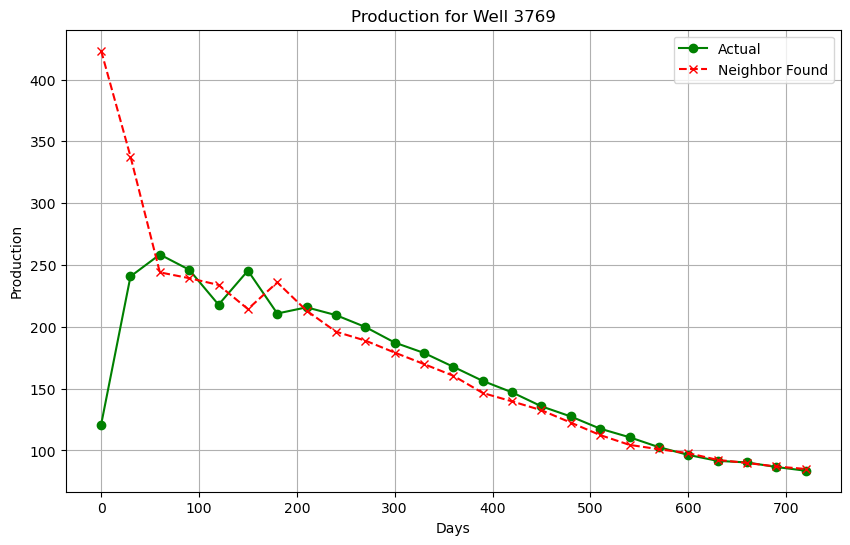

In [426]:
# Example
# Filter data for the selected well
actual_data = check_stump_patterns[check_stump_patterns['current_well_name'] == 'ELROY KADRMAS 4-3-10H-143-96']    
neighbor_data = check_stump_patterns[check_stump_patterns['current_well_name'] == 'FEDERAL TRIPPELL 32-16H']    
# Ensure data is sorted by time if not already
actual_data = actual_data.sort_values('producing_days')


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual_data['producing_days'], actual_data['rolling_oil_mean'], label='Actual', marker='o', linestyle='-', color='green')
plt.plot(neighbor_data['producing_days'], neighbor_data['rolling_oil_mean'], label='Neighbor Found', marker='x', linestyle='--', color='red')

plt.title(f'Production for Well {motif_idx}')
plt.xlabel('Days')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()

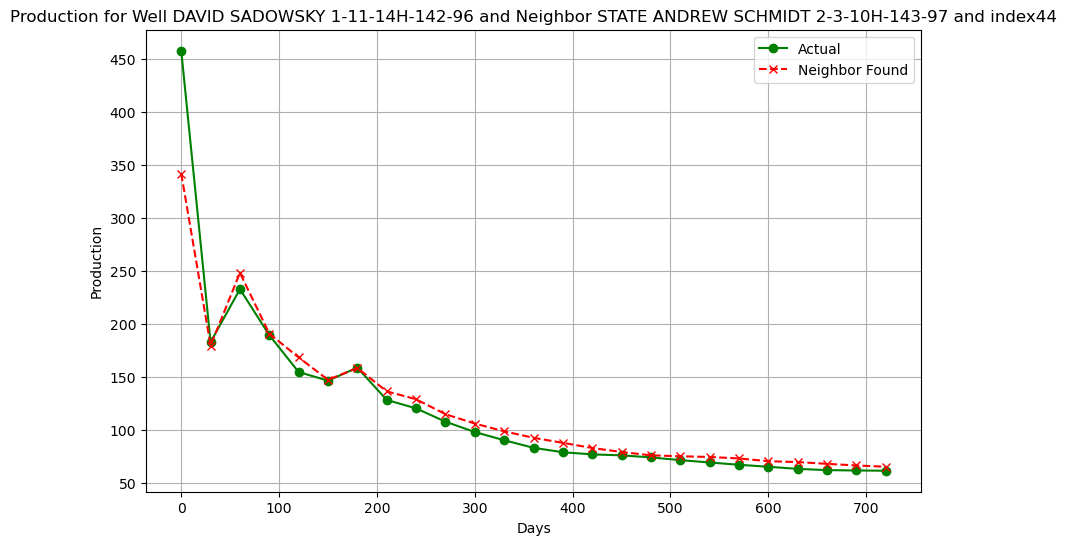

In [479]:
# Set a dynamic pair index to view a specific motif-neighbor pair
#for s in range(0,62,2):
s = 44  # Adjust this index to view a different pair

# Extract indices and names for the motif and its nearest neighbor
view_motif_idx = motif_neighbor_pairs[s][0]  # Motif index
motif_name = check_stump_patterns.iloc[view_motif_idx].current_well_name  # Get well name for the motif
neighbor_idx = motif_neighbor_pairs[s][1]  # Neighbor index
neighbor_name = check_stump_patterns.iloc[neighbor_idx].current_well_name  # Get well name for the neighbor

# Filter the data for the selected wells (motif and neighbor)
actual_data = check_stump_patterns[check_stump_patterns['current_well_name'] == motif_name]  # Data for motif well
neighbor_data = check_stump_patterns[check_stump_patterns['current_well_name'] == neighbor_name]  # Data for neighbor well

# Ensure the data is sorted by 'producing_days' for consistent plotting
actual_data = actual_data.sort_values('producing_days')
neighbor_data = neighbor_data.sort_values('producing_days')

# Plotting the motif and neighbor production data
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(
    actual_data['producing_days'], actual_data['rolling_oil_mean'], 
    label='Actual', marker='o', linestyle='-', color='green'
)  # Plot the motif production data
plt.plot(
    neighbor_data['producing_days'], neighbor_data['rolling_oil_mean'], 
    label='Neighbor Found', marker='x', linestyle='--', color='red'
)  # Plot the neighbor production data

# Add a title and labels
plt.title(f'Production for Well {motif_name} and Neighbor {neighbor_name} and index{s}')
plt.xlabel('Days')  # X-axis label
plt.ylabel('Production')  # Y-axis label

# Add legend and grid for better readability
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


## motif discovery and neighbor analysis in oil and gas production
1. Building Type Curves for Reservoir Characterization
- Why: Analog wells with similar production behavior can help create representative type curves for specific reservoirs, enabling better forecasting and reserves estimation.
- How: Use motif discovery to group wells with similar production trends and create a composite type curve for each group, reflecting the reservoir's performance.
2. Understanding Completion and Rock Property Relationships
- Why: Comparing wells with similar production patterns but different completions or rock properties can reveal the impact of engineering and geological factors on well performance.
- How: Use motif-neighbor pairs to investigate how variables like proppant concentration, fluid volumes, or lithology affect production outcomes for similar wells.
3. Optimizing Drilling Locations
- Why: Identify drilling opportunities in areas with geological and operational similarities to high-performing wells.
- How: Apply motif analysis to highlight underdeveloped areas near wells with favorable production trends and similar reservoir characteristics.
4. Production Behavior Anomaly Detection
- Why: Detect wells with unusual or problematic production behavior (e.g., rapid declines, erratic trends) compared to analog wells.
- How: Flag wells with motif patterns that deviate significantly from their nearest neighbors and investigate potential issues like equipment failure or operational inefficiencies.
5. Well Spacing Optimization
- Why: Analyze how well spacing impacts production by comparing motif neighbors with varying proximities.
- How: Correlate spacing with motif similarities to refine development plans and maximize resource recovery while minimizing interference.
6. Forecasting and Predictive Analytics
- Why: Use production trends of motif neighbors as a benchmark to forecast the performance of new wells.
- How: Incorporate motif neighbors' historical data into predictive models for estimating future production trajectories.
7. Reservoir Management and Development Planning
- Why: Understand regional variations in production performance across a reservoir.
- How: Group wells with similar motifs to segment the reservoir into performance clusters for targeted development and optimization.
8. Enhanced Machine Learning Features
- Why: Use motif distances and nearest neighbor relationships as features for predictive machine learning models.
- How: Integrate motif indices and similarity metrics into supervised models for predicting production, EUR, or operational efficiency.
9. Economic Benchmarking
- Why: Compare the cost-effectiveness of wells with similar production patterns to identify best practices.
- How: Analyze motif neighbors with varying CAPEX and OPEX to optimize economic performance.
10. Exploration of Historical Patterns
- Why: Identify historical production trends that correspond to specific reservoir or operational conditions.
- How: Use motif discovery to investigate wells drilled during different time periods or under varying market conditions.
11. Geological Insights
- Why: Validate geological models by comparing motif neighbors in similar structural or stratigraphic settings.
- How: Overlay motif results with seismic, core, or log data to refine reservoir characterization.


In [ ]:
# How can we use this information?
# Plot where these two wells are and maybe look at similarities in geology and completion

In [575]:
# Example data for two wells 
map_data_dict  = {
    'current_well_name': ['DAVID SADOWSKY 1-11-14H-142-96', 'STATE ANDREW SCHMIDT 2-3-10H-143-97'],
    'latitude': [47.140916, 47.240063],  
    'longitude': [-102.814603, -102.961641],
     'perf_interval':[9895,10108], 
    'Proppant_Volume': [2163060, 188994],
    'Fluid_Volume': [53331, 81104],
    'Stage_Spacing': [471, 316],
    'Stage_Count': [21, 32],
    'Formation': ['Bakken', 'Bakken'],
    'is_motif_or_neighbor': [True,True],
    'scale' : [10,10],
}

# Convert to DataFrame
map_data = pd.DataFrame(map_data_dict)



In [564]:
add_other_wells = daily_df[~daily_df['current_well_name'].isin(['DAVID SADOWSKY 1-11-14H-142-96', 'STATE ANDREW SCHMIDT 2-3-10H-143-97'])]
add_other_wells = add_other_wells[['current_well_name','latitude','longitude','perfs']].drop_duplicates()

# Clean the 'perfs' column to extract numeric ranges
add_other_wells['perfs_cleaned'] = add_other_wells['perfs'].apply(
    lambda x: re.search(r'\d+-\d+', x).group() if isinstance(x, str) and re.search(r'\d+-\d+', x) else None
)
# Calculate perf_interval from perfs
add_other_wells['perf_interval'] = add_other_wells['perfs_cleaned'].apply(
    lambda x: int(x.split('-')[1]) - int(x.split('-')[0]) if isinstance(x, str) and '-' in x else None
)
add_other_wells.drop(columns=['perfs','perfs_cleaned'], inplace=True)
# Add empty columns for completion data
add_other_wells['Proppant_Volume'] = None
add_other_wells['Fluid_Volume'] = None
add_other_wells['Stage_Spacing'] = None
add_other_wells['Stage_Count'] = None
add_other_wells['Formation'] = None
add_other_wells['is_motif_or_neighbor'] = False
add_other_wells['scale'] = 2

In [565]:
# Append other wells to map_data
map_data = pd.concat([map_data, add_other_wells], ignore_index=True)

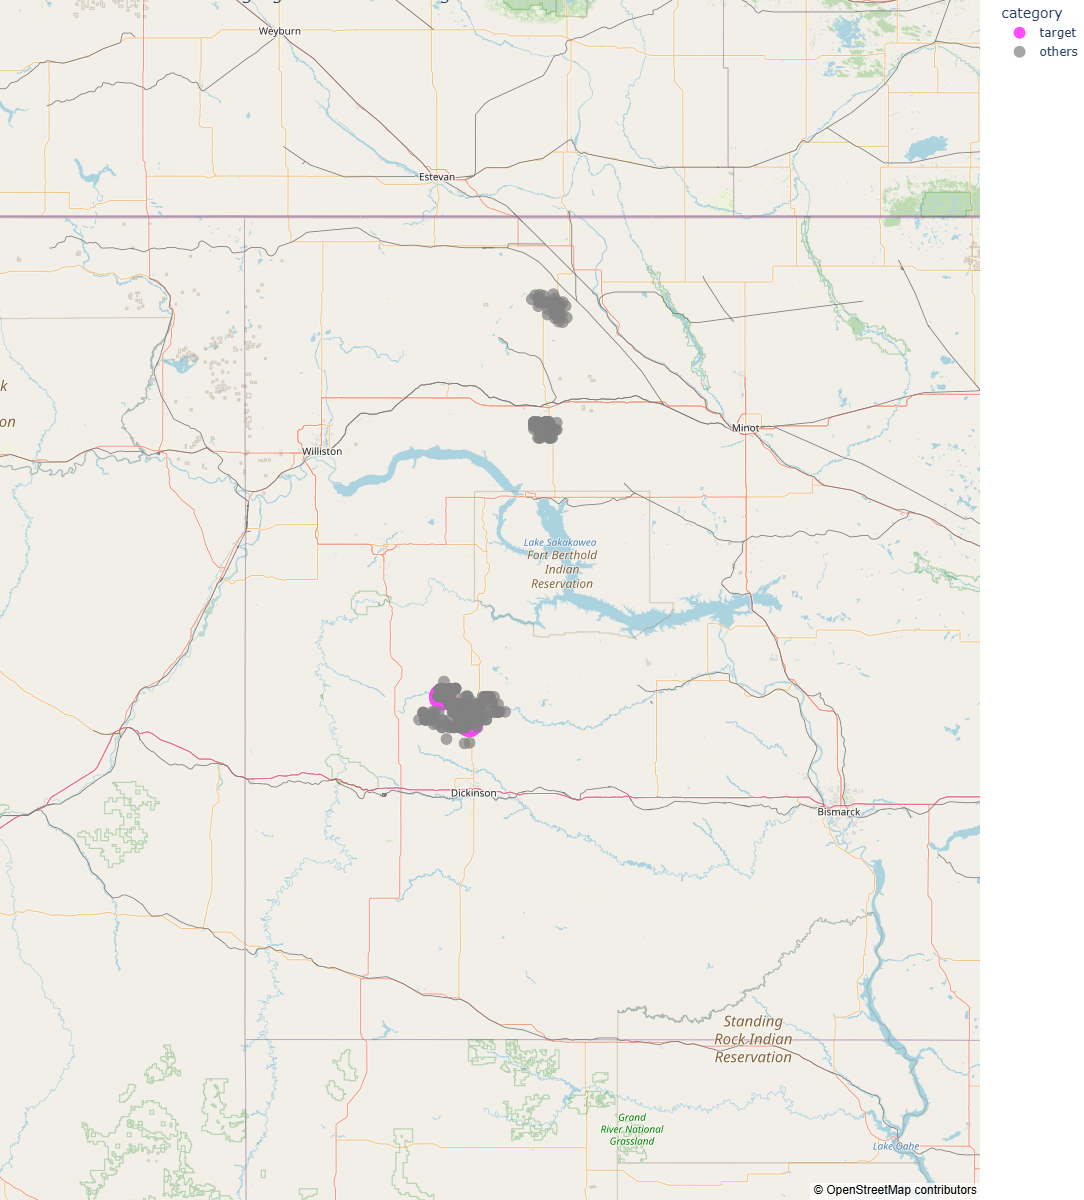

In [566]:
# Add a color column based on whether the well is the motif or its neighbor
map_data['category'] = map_data['is_motif_or_neighbor'].apply(
    lambda x: 'target' if x else 'others'
)

# Plot map using Plotly Express
map_fig = px.scatter_mapbox(
    map_data,
    lat='latitude',
    lon='longitude',
    hover_name='current_well_name',
    color='category',  # Use the 'category' column for coloring
    size='scale',  
    color_discrete_map={'target': 'fuchsia', 'others': 'gray'}, 
    zoom=7,
    title='Well Locations with Highlighted Motif and Neighbor'
)

# Configure map style
map_fig.update_layout(
    mapbox_style='open-street-map',
    height=1200,
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    showlegend=True  # Show legend to clarify color meanings
)

# Show the map
map_fig.show()


In [427]:
mp = matrix_profile
all_chain_set, unanchored_chain = stumpy.allc(mp[:, 2], mp[:, 3])

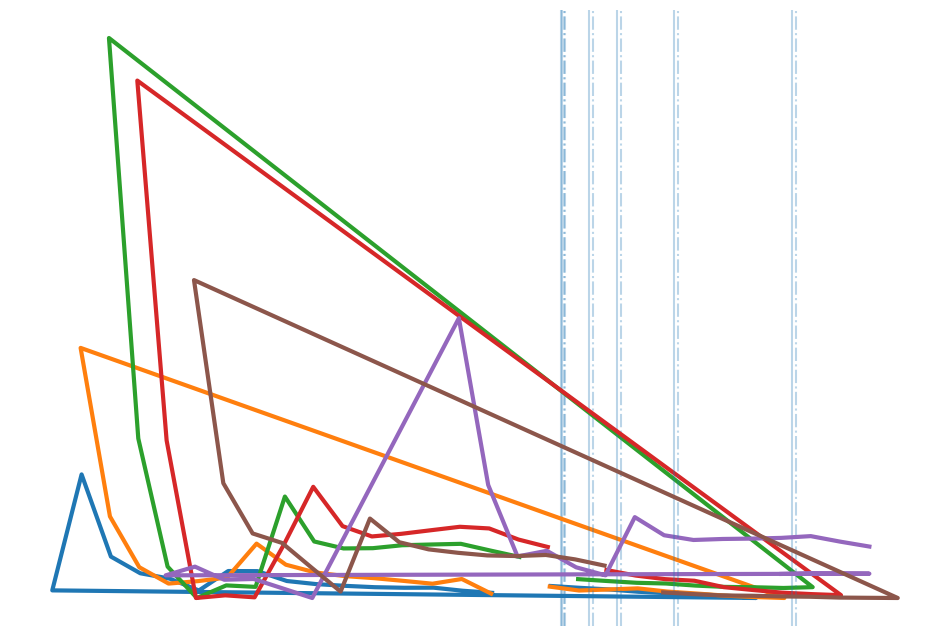

In [450]:
plt.axis('off')
for i in range(unanchored_chain.shape[0]):
    data = stump_df['rolling_oil_mean'].iloc[unanchored_chain[i]:unanchored_chain[i]+m].reset_index().values
    x =data[:, 1]
    y = data[:, 2]
    plt.axvline(x=x[0]-x.min()+(m+5)*i + 11, alpha=0.3)
    plt.axvline(x=x[0]-x.min()+(m+5)*i + 15, alpha=0.3, linestyle='-.')
    plt.plot(x-x.min()+(m+5)*i, y-y.min(), linewidth=3)
plt.show()